In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import pathlib

In [2]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Extraction

## directory of dataset

In [3]:
# directory of dataset
train_directory = "E:/programing/Classification/dataset/seg_train"
test_directory = "E:/programing/Classification/dataset/seg_test"

## convert to WindowsPath

In [4]:
# convert to WindowsPath
train_directory = pathlib.Path(train_directory)
test_directory = pathlib.Path(test_directory)
train_directory

WindowsPath('E:/programing/Classification/dataset/seg_train')

## Class Name

In [5]:
#Class Name
CLASS_NAMES = np.array([item.name for item in train_directory.glob('*')])
CLASS_NAMES

array(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'],
      dtype='<U9')

In [6]:
full_dataset = tf.data.Dataset.list_files(str(train_directory/'*/*'))

## Validation split

In [7]:
#Validation split
validation_split = 0.2

DATASET_SIZE = len(list(full_dataset))
print("Dataset size: ", DATASET_SIZE)
train_size = int((1-validation_split) * DATASET_SIZE)
print("train size: ", train_size)
train_dataset = full_dataset.take(train_size)
validation_dataset = full_dataset.skip(train_size)

Dataset size:  14034
train size:  11227


## Get label of Image (One-Hot)

In [8]:
def get_label(file_path):

  parts = tf.strings.split(file_path, os.path.sep)

  return parts[-2] == CLASS_NAMES

In [9]:
get_label("E:\\programing\\Classification\\dataset\\seg_train\\forest\\49.jpg").numpy()

array([False,  True, False, False, False, False])

## Load Image

In [10]:
def load_img(image_path):
    img = tf.io.read_file(image_path)
    
    img = tf.image.decode_image(img, 3, expand_animations=False)
    
    img = tf.cast(img, tf.float32)
    
    return img

In [11]:
def normalize(image):
    image = (image / 255.0)
    return image

In [12]:
def resize(image,height, width):
    image = tf.image.resize(image, (height, width),
                                 method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = tf.image.resize_with_crop_or_pad(image, height, width)
    return image

In [13]:
def load_image_with_label(image_path):
    label = get_label(image_path)
    img = load_img(image_path)
    return img, label

In [14]:
def load_image_train(image_file):
    
    image, label = load_image_with_label(image_file)
    image = resize(image, 150, 150)
    image = augment_data(image)
    image = normalize(image)
    
    return image, label

In [15]:
def load_image_test(image_file):
    
    image, label = load_image_with_label(image_file)
    image = resize(image, 150, 150)
    image = normalize(image)

    return image, label

## Augment Data

In [16]:
def augment_data(image):

    image = tf.image.random_brightness(image, max_delta=0.05)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = tf.image.random_flip_left_right(image)
    
    # image = tf.image.adjust_brightness(image, 0.2) 
    # image = tf.image.adjust_contrast(image, 0.2)
    # image = tf.image.flip_left_right(image)

    return image

# Transform Data

In [17]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [18]:
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [19]:
validation_dataset = validation_dataset.map(load_image_test)
validation_dataset = validation_dataset.batch(BATCH_SIZE)

# Model - Functional - VGG16

In [20]:
from tensorflow.keras.applications import VGG16 
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.optimizers import Adam


IMG_SIZE = (150,150,3)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=IMG_SIZE)
base_model.trainable = False  

inputs = layers.Input(shape=IMG_SIZE)

x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)  
x = layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(6, activation='softmax')(x)

model = models.Model(inputs, outputs)

model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                             

## Callbacks

In [21]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_accuracy'),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, monitor='val_accuracy')
]

# Transfer Learning

In [22]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=25,
    callbacks=callbacks
)

Epoch 1/25
351/351 [==============================] - 114s 274ms/step - loss: 0.8692 - accuracy: 0.6633 - val_loss: 0.5015 - val_accuracy: 0.8183 - lr: 0.0010
Epoch 2/25
351/351 [==============================] - 79s 223ms/step - loss: 0.6269 - accuracy: 0.7657 - val_loss: 0.4688 - val_accuracy: 0.8247 - lr: 0.0010
Epoch 3/25
351/351 [==============================] - 77s 218ms/step - loss: 0.5837 - accuracy: 0.7871 - val_loss: 0.4265 - val_accuracy: 0.8657 - lr: 0.0010
Epoch 4/25
351/351 [==============================] - 60s 169ms/step - loss: 0.5630 - accuracy: 0.7942 - val_loss: 0.4535 - val_accuracy: 0.8326 - lr: 0.0010
Epoch 5/25
351/351 [==============================] - 58s 165ms/step - loss: 0.5571 - accuracy: 0.7958 - val_loss: 0.4220 - val_accuracy: 0.8600 - lr: 0.0010
Epoch 6/25
351/351 [==============================] - 58s 165ms/step - loss: 0.5527 - accuracy: 0.7976 - val_loss: 0.4347 - val_accuracy: 0.8443 - lr: 0.0010
Epoch 7/25
351/351 [==============================]

# Fine-Tuning

In [23]:
base_model.trainable = True

In [24]:
N = 5
for layer in base_model.layers[:-N]:
    layer.trainable = False
for layer in base_model.layers[-N:]:
    layer.trainable = True

In [25]:
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                             

In [27]:
history_ft = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=25    
)

Epoch 1/25
351/351 [==============================] - 71s 196ms/step - loss: 0.4610 - accuracy: 0.8390 - val_loss: 0.3276 - val_accuracy: 0.9002
Epoch 2/25
351/351 [==============================] - 66s 188ms/step - loss: 0.3686 - accuracy: 0.8784 - val_loss: 0.2637 - val_accuracy: 0.9198
Epoch 3/25
351/351 [==============================] - 66s 186ms/step - loss: 0.3274 - accuracy: 0.8949 - val_loss: 0.2575 - val_accuracy: 0.9177
Epoch 4/25
351/351 [==============================] - 65s 185ms/step - loss: 0.3097 - accuracy: 0.9013 - val_loss: 0.2294 - val_accuracy: 0.9287
Epoch 5/25
351/351 [==============================] - 65s 186ms/step - loss: 0.2745 - accuracy: 0.9141 - val_loss: 0.2136 - val_accuracy: 0.9337
Epoch 6/25
351/351 [==============================] - 67s 190ms/step - loss: 0.2597 - accuracy: 0.9186 - val_loss: 0.1991 - val_accuracy: 0.9416
Epoch 7/25
351/351 [==============================] - 66s 186ms/step - loss: 0.2499 - accuracy: 0.9205 - val_loss: 0.1951 - val_ac

# Evaluate

In [28]:
test_dataset = tf.data.Dataset.list_files(str(test_directory/'*/*'))

In [29]:
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [30]:
test_loss, test_acc = model.evaluate(test_dataset)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)

94/94 [==============================] - 15s 163ms/step - loss: 0.2943 - accuracy: 0.9237
Test accuracy: 0.9236666560173035
Test loss: 0.2943442165851593


# predict

In [31]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

In [35]:
image_paths = [
    "E:/programing/Classification/dataset/seg_pred/3.jpg",
    "E:/programing/Classification/dataset/seg_pred/5.jpg",
    "E:/programing/Classification/dataset/seg_pred/6.jpg",
    "E:/programing/Classification/dataset/seg_pred/11.jpg",
    "E:/programing/Classification/dataset/seg_pred/144.jpg",
]

In [36]:
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

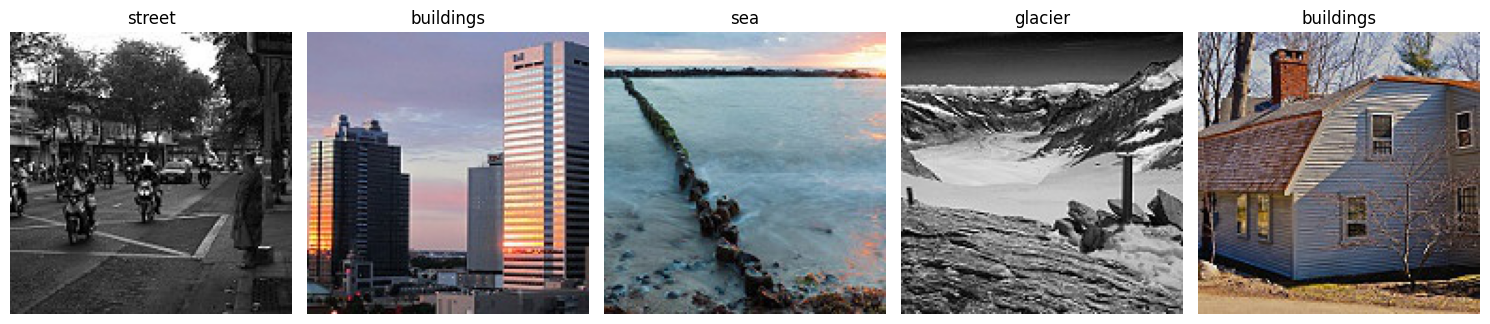

In [37]:
plt.figure(figsize=(15, 8))

for i, img_path in enumerate(image_paths):
    # load + preprocess
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # predict
    preds = model.predict(img_array, verbose=0)
    class_id = np.argmax(preds[0])
    label = class_names[class_id]

    # Show
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

plt.tight_layout()
plt.show()